In [11]:
import torch
torch.cuda.set_device(1)

from cldm.model import create_model, load_state_dict
model = create_model("./models/cldm_v15_unicontrol_v11.yaml").cpu()


ControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_

In [2]:
import argparse
import logging
import math
import os
import random
import shutil
import warnings
from pathlib import Path

import numpy as np
import PIL
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from huggingface_hub import create_repo, upload_folder
import cv2

# TODO: remove and import from diffusers.utils when the new version of diffusers is released
from packaging import version
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
    StableDiffusionPipeline,
    UNet2DConditionModel,
)
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available
from cldm.model import create_model, load_state_dict

# validation necessity
from pytorch_lightning import seed_everything
import einops
from cldm.ddim_unicontrol_hacked import DDIMSampler


In [6]:
PIL_INTERPOLATION = {
    "linear": PIL.Image.Resampling.BILINEAR,
    "bilinear": PIL.Image.Resampling.BILINEAR,
    "bicubic": PIL.Image.Resampling.BICUBIC,
    "lanczos": PIL.Image.Resampling.LANCZOS,
    "nearest": PIL.Image.Resampling.NEAREST,
}

imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

class MyDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        resolution=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):
        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.resolution = resolution
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL_INTERPOLATION["linear"],
            "bilinear": PIL_INTERPOLATION["bilinear"],
            "bicubic": PIL_INTERPOLATION["bicubic"],
            "lanczos": PIL_INTERPOLATION["lanczos"],
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def resize_image_control(self, control_image, resolution):
        H, W, C = control_image.shape
        if W >= H:
            crop = H
            crop_l = random.randint(0, W-crop) # 2nd value is inclusive
            crop_r = crop_l + crop
            crop_t = 0
            crop_b = H
        else:
            crop = W
            crop_t = random.randint(0, H-crop) # 2nd value is inclusive
            crop_b = crop_t + crop
            crop_l = 0
            crop_r = W
        control_image = control_image[ crop_t: crop_b, crop_l:crop_r]
        H = float(H)
        W = float(W)
        k = float(resolution) / min(H, W)
        img = cv2.resize(control_image, (resolution, resolution), interpolation=cv2.INTER_LANCZOS4 if k > 1 else cv2.INTER_AREA)
        return img, [crop_t/H, crop_b/H, crop_l/W, crop_r/W]
    
    def resize_image_target(self, target_image, resolution, sizes):
        H, W, C = target_image.shape
        crop_t_rate, crop_b_rate, crop_l_rate, crop_r_rate = sizes[0], sizes[1], sizes[2], sizes[3]
        crop_t, crop_b, crop_l, crop_r = int(crop_t_rate*H), int(crop_b_rate*H), int(crop_l_rate*W), int(crop_r_rate*W)
        target_image = target_image[ crop_t: crop_b, crop_l:crop_r]
        H = float(H)
        W = float(W)
        k = float(resolution) / min(H, W)
        img = cv2.resize(target_image, (resolution, resolution), interpolation=cv2.INTER_LANCZOS4 if k > 1 else cv2.INTER_AREA)
        return img
    
    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        source_img = cv2.imread(self.image_paths[i % self.num_images],cv2.IMREAD_GRAYSCALE)
        source_img = np.repeat(source_img[:, :, np.newaxis], 3, axis=2)
        target_img = cv2.imread(self.image_paths[i % self.num_images])

        placeholder_string = self.placeholder_token
        prompt = random.choice(self.templates).format(placeholder_string)

        # prompt = self.tokenizer(
        #     text,
        #     padding="max_length",
        #     truncation=True,
        #     max_length=self.tokenizer.model_max_length,
        #     return_tensors="pt",
        # ).input_ids[0]

        source_img,  sizes = self.resize_image_control(source_img, self.resolution)
        target_img = self.resize_image_target(target_img, self.resolution, sizes)

        # Do not forget that OpenCV read images in BGR order.
        source_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
        target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)

        # Normalize source images to [0, 1].
        source_img = source_img.astype(np.float32) / 255.0

        # Normalize target images to [-1, 1].
        target_img = (target_img.astype(np.float32) / 127.5) - 1.0
        
        prompt = prompt if random.uniform(0, 1) > 0.3 else '' # dropout rate 30%
        return dict(jpg=target_img, txt=prompt, hint=source_img, task="control_grayscale")


In [ ]:
tokenizer = model.cond_stage_model.tokenizer

placeholder_token = "<real_hand>"
num_vectors = 5

placeholder_tokens = [placeholder_token]

if num_vectors < 1:
    raise ValueError(f"--num_vectors has to be larger or equal to 1, but is {num_vectors}")

# add dummy tokens for multi-vector
additional_tokens = []
for i in range(1, num_vectors):
    additional_tokens.append(f"{placeholder_token}_{i}")
placeholder_tokens += additional_tokens

num_added_tokens = tokenizer.add_tokens(placeholder_tokens)
if num_added_tokens != num_vectors:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

In [8]:
# Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode("hand", add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_ids = tokenizer.convert_tokens_to_ids(placeholder_tokens)

train_dataset = MyDataset(
    data_root="./my_data/H3D_samples",
    tokenizer=tokenizer,
    resolution=256,
    placeholder_token=(" ".join(tokenizer.convert_ids_to_tokens(placeholder_token_ids))),
    repeats=100,
    learnable_property="style",
    center_crop=False,
    set="train",
)

In [9]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, num_workers=1
)

In [13]:
model = model.to("cuda:1")

In [19]:
batch["task"]

['control_grayscale']

Global seed set to 61


Data shape for DDIM sampling is (2, 4, 32, 32), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:05<00:00,  9.42it/s]


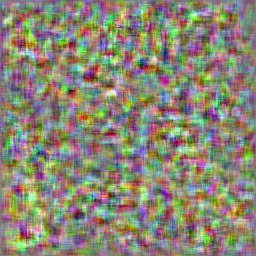

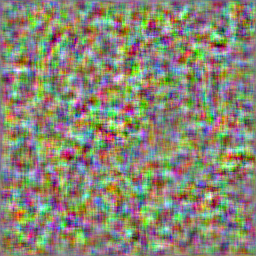

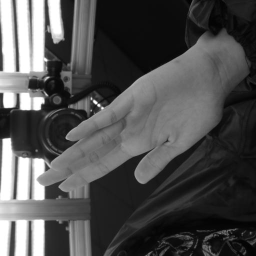

In [16]:
model.eval()
num_samples = 2
guess_mode = False
ddim_steps=50
ddim_sampler = DDIMSampler(model)
a_prompt = 'best quality, extremely detailed'
 
seed = 61
with torch.no_grad():
    for idx, batch in enumerate(train_dataloader):
        prompt = batch['txt'][0]

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        control = batch['hint'].squeeze(0).to("cuda:1") # torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
        H, W, C = control.shape

        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        task_dic = {}
        task_dic['name'] = "control_grayscale" # batch['task'][0]
        task_instruction = "gray image to color image" # batch['instruction'][0]
        task_dic['feature'] = model.get_learned_conditioning(task_instruction)[:,:1,:]

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)], "task": task_dic}
        un_cond = {"c_concat": [torch.zeros_like(control)] if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([""] * num_samples)]}
        shape = (4, H // 8, W // 8)

        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                    shape, cond, verbose=False, eta=0,
                                                    unconditional_guidance_scale=9,
                                                    unconditional_conditioning=un_cond)
        x_samples = model.decode_first_stage(samples)

        x_checked_image_torch = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)
        # x_samples = x_samples.cpu().permute(0, 2, 3, 1).numpy()

        # x_checked_image, has_nsfw_concept = check_sa  fety(x_samples)
        # x_checked_image_torch = torch.from_numpy(x_checked_image).permute(0, 3, 1, 2)
        base_count = 0
        for x_sample in x_checked_image_torch:
            x_sample = 255. * einops.rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                        
            img = Image.fromarray(x_sample.astype(np.uint8))
            display(img)
            # img.save(os.path.join(sample_path, prompt.replace(" ", "-")[:-1] +'-' + f"{base_count:05}" + ".png"))
            base_count += 1
        control_img = Image.fromarray((batch['hint'].squeeze(0).cpu().numpy() *  255.0).astype(np.uint8))
        display(control_img)
        break
        # control_img.save(os.path.join(sample_path, prompt.replace(" ", "-")[:-1] + '-'+ 'control' + ".png"))

In [21]:
batch.keys()

dict_keys(['jpg', 'txt', 'hint', 'task'])

In [15]:
batch["hint"].shape

torch.Size([12, 256, 256, 3])